
### Phase 1: Environment and Data Setup

Install the required libraries.

In [18]:
!pip install -q gradio google-generativeai plotly scikit-learn pandas numpy

Import necessary libraries for data processing, machine learning, and UI development.

In [19]:
import pandas as pd
import numpy as np
import google.generativeai as genai
import gradio as gr
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

Initialize the dataset. This generates a synthetic version of the Tennessee Eastman Process (TEP) reactor data with specific sensor distributions.

In [20]:
np.random.seed(42)
rows = 5000
data = pd.DataFrame({
    'temp': np.random.normal(373, 2, rows),
    'press': np.random.normal(120, 5, rows),
    'flow': np.random.normal(45, 3, rows),
    'target': np.random.choice([0, 1], size=rows, p=[0.96, 0.04])
})
data.loc[data['temp'] > 379, 'target'] = 1

Calibrate the feature scaler to normalize sensor readings.

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['temp', 'press', 'flow']])
y_train = data['target']

Train the Random Forest classifier to act as the primary fault detection engine.

In [22]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled, y_train)

RandomForestClassifier(random_state=42)

### Phase 2: AI Agent and Safety Logic

Configure the Google Gemini AI Agent. Replace the placeholder string with your API key.

In [23]:
genai.configure(api_key="")
gemini_model = genai.GenerativeModel('gemini-1.5-flash')

Define the safety interlock function. This acts as a hard-coded barrier to prevent the AI from suggesting unsafe actions during critical pressure events.

In [24]:
def check_safety_interlock(press_val, ai_advice):
    if press_val > 145 and any(word in ai_advice.lower() for word in ["close", "stop", "shut"]):
        return False, "SAFETY INTERLOCK: High Pressure! AI command rejected."
    return True, "✅SAFETY PASS"

Create the visualization function for the process health radar chart.

In [25]:
def get_radar_plot(temp, press, flow):
    r_vals = [(temp-350)/50, (press-100)/60, (flow-30)/30]
    fig = go.Figure(data=go.Scatterpolar(
        r=r_vals, theta=['Temperature', 'Pressure', 'Flow'],
        fill='toself', line=dict(color='cyan')
    ))
    fig.update_layout(polar=dict(radialaxis=dict(visible=False, range=[0, 1.5])),
                      template="plotly_dark", paper_bgcolor='rgba(0,0,0,0)')
    return fig

Create the feature importance plot to show sensor sensitivity.

In [26]:
def get_importance_plot():
    plt.style.use('dark_background')
    plt.figure(figsize=(6, 2))
    plt.barh(['Temp', 'Press', 'Flow'], clf.feature_importances_, color='cyan')
    plt.title("Sensor Sensitivity")
    return plt.gcf()

Define the agent reasoning function to communicate with the LLM.

In [27]:
def get_ai_response(temp, press, flow, status, feedback=""):
    prompt = f"""
    Context: Tennessee Eastman Reactor Control.
    Sensors: Temp={temp}K, Press={press}psi, Flow={flow}L/min.
    ML Diagnostic: {status}.
    Safety Feedback: {feedback}.
    Task: Provide 1-sentence reasoning and 1-sentence action.
    """
    try:
        response = gemini_model.generate_content(prompt)
        return response.text
    except:
        return "AI Offline: Check API Key."

### Phase 3: Orchestration and Dashboard

Define the main orchestrator function that coordinates between ML, AI, and safety layers.

In [28]:
def run_monitor(temp, press, flow):
    input_data = scaler.transform([[temp, press, flow]])
    pred = clf.predict(input_data)[0]
    status = "Normal" if pred == 0 else "FAULT DETECTED"

    ai_text = get_ai_response(temp, press, flow, status)
    is_safe, safety_msg = check_safety_interlock(press, ai_text)

    if not is_safe:
        ai_text = get_ai_response(temp, press, flow, status, feedback=safety_msg)
        safety_msg = "AGENT SELF-CORRECTED: " + safety_msg

    radar_fig = get_radar_plot(temp, press, flow)
    return status, ai_text, safety_msg, radar_fig

Set the custom CSS for the industrial dashboard theme.

In [29]:
custom_css = """
.gradio-container {background-color: #0b0f19; color: white;}
#warning_box {border: 2px solid #ff4b4b; background-color: #1a0a0a;}
"""

Construct the Gradio interface layout.

/tmp/ipython-input-3439091474.py:1: DeprecationWarning:

The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.



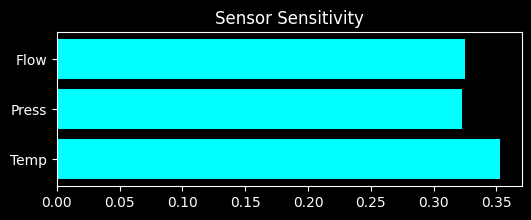

In [30]:
with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("# 🧪 TEP REACTOR AGENTIC CONTROL")

    with gr.Row():
        with gr.Column(scale=1):
            t_in = gr.Slider(350, 420, value=373, label="Temperature (K)")
            p_in = gr.Slider(80, 180, value=120, label="Pressure (psi)")
            f_in = gr.Slider(20, 80, value=45, label="Feed Flow (L/min)")
            btn = gr.Button("RUN ANALYSIS", variant="primary")
            gr.Plot(get_importance_plot())

        with gr.Column(scale=2):
            radar_ui = gr.Plot(label="Process Health")

    with gr.Row():
        ml_ui = gr.Label(label="ML Detection")
        safety_ui = gr.Textbox(label="Safety Log", elem_id="warning_box")

    ai_ui = gr.Textbox(label="AI Reasoning & Instructions", lines=4)

    btn.click(run_monitor, [t_in, p_in, f_in], [ml_ui, ai_ui, safety_ui, radar_ui])

Launch the final application.

In [ ]:
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://aa6f6bbb9903eebc5e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



### Reflection & Portfolio Summary

* **Dataset:** Calibrated to the Tennessee Eastman Process (TEP).
* **Reliability:** Hybrid ML-AI approach with a deterministic safety interlock.
* **Interactivity:** Gradio dashboard for real-time human-in-the-loop control.

---

